In [6]:
import utilities as utils

In [7]:
data_path_1: str = '../../../Data/phase1/'   
data_path_2: str = '../../../Data/phase2/'   

data_set_1: list = [ 'Traffic_type_seed.csv', 'Application_type_seed.csv' ] 

data_set_2: list = [ 'Traffic_type_test.csv', 'Application_type_test.csv' ] 


file_path_1       = utils.get_file_path(data_path_1)
file_path_2       = utils.get_file_path(data_path_2)
file_set_1 : list = list(map(file_path_1, data_set_1))
file_set_2 : list = list(map(file_path_2, data_set_2))

file_set : list   = file_set_1 + file_set_2 
data_set   : list = data_set_1 + data_set_2 
current_job: int  = 0

utils.data_set = data_set
utils.file_set = file_set

In [8]:
print(f'We will be using {len(file_set)} files:')
utils.pretty(file_set)

We will be using 4 files:
[   '../../../Data/phase1/Traffic_type_seed.csv',
    '../../../Data/phase1/Application_type_seed.csv',
    '../../../Data/phase2/Traffic_type_test.csv',
    '../../../Data/phase2/Application_type_test.csv']


In [9]:
baseline_traffic_seed = utils.examine_dataset(1)
baseline_application_seed = utils.examine_dataset(2)
baseline_traffic_test = utils.examine_dataset(3)
baseline_application_test = utils.examine_dataset(4)

Dataset 1/4: We now look at ../../../Data/phase1/Traffic_type_seed.csv


Loading Dataset: ../../../Data/phase1/Traffic_type_seed.csv
	To Dataset Cache: ./cache/Traffic_type_seed.csv.pickle


        File:				../../../Data/phase1/Traffic_type_seed.csv  
        Job Number:			1
        Shape:				(115670, 64)
        Samples:			115670 
        Features:			64
    
Dataset 2/4: We now look at ../../../Data/phase1/Application_type_seed.csv


Loading Dataset: ../../../Data/phase1/Application_type_seed.csv
	To Dataset Cache: ./cache/Application_type_seed.csv.pickle


        File:				../../../Data/phase1/Application_type_seed.csv  
        Job Number:			2
        Shape:				(113620, 64)
        Samples:			113620 
        Features:			64
    
Dataset 3/4: We now look at ../../../Data/phase2/Traffic_type_test.csv


Loading Dataset: ../../../Data/phase2/Traffic_type_test.csv
	To Dataset Cache: ./cache/Traffic_type_test.csv.pickle


        File:				../../../Data/phase2/Traffic_type_test.csv  
     

In [10]:
baseline_traffic_seed               : dict = utils.package_data_for_inspection_with_label(
                                                            utils.prune_dataset(baseline_traffic_seed, ['Application Type']), 'Traffic_Dataset_seed')
baseline_application_seed           : dict = utils.package_data_for_inspection_with_label(
                                                            utils.prune_dataset(baseline_application_seed, ['Traffic Type']), 'Application_Dataset_seed')
baseline_traffic_test               : dict = utils.package_data_for_inspection_with_label(
                                                            utils.prune_dataset(baseline_traffic_test, ['Application Type']), 'Traffic_Dataset_test')
baseline_application_test           : dict = utils.package_data_for_inspection_with_label(
                                                            utils.prune_dataset(baseline_application_test, ['Traffic Type']), 'Application_Dataset_test')


        Shape:				(115670, 63)
        Samples:			115670 
        Features:			63
    

        Shape:				(113620, 63)
        Samples:			113620 
        Features:			63
    

        Shape:				(1950, 63)
        Samples:			1950 
        Features:			63
    

        Shape:				(4000, 63)
        Samples:			4000 
        Features:			63
    


In [11]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
def run_shallow_learning_experiment(df: utils.pd.DataFrame, name: str, target_label: str, classifier, param_grid: str, split=0.2, categorical : list = ['Protocol'], leave_out: list = []) -> utils.Model_data:
    '''
        Run binary classification using a shallow learning model
        returns the 10-tuple Model_data
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var: str = target_label

    categorical_features: list = []
    untouched_features  : list = []

    for x in categorical:
        if x in df.columns:
            categorical_features.append(x)

    for x in leave_out:
        if x in df.columns:
            untouched_features.append(x)
        
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]) - set(untouched_features))

    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [utils.FillMissing, utils.Categorify, utils.Normalize]
    splits = utils.RandomSplitter(valid_pct=split, seed=utils.seed)(utils.range_of(df))
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = utils.TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # We use fastai to quickly extract the names of the classes as they are mapped to the encodings
    dls = to.dataloaders(bs=64)
    model = utils.tabular_learner(dls)
    classes : list = list(model.dls.vocab)


    # extract the name from the path
    p = utils.pathlib.Path(name)
    name: str = str(p.parts[-1])


    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()


    # Now that we have the train and test datasets, we set up a gridsearch of the K-NN classifier
    # using SciKitLearn and print the results 
    pipe = utils.Pipeline([
    ('scaler', utils.StandardScaler()),
    ('selector', utils.VarianceThreshold()),
    ('classifier', classifier)
    ])
    pipe.fit(X_train, y_train)
    model = utils.GridSearchCV(pipe, param_grid, cv=3).fit(X_train, y_train)
    prediction = model.predict(X_test)
    prediction_prob = model.predict_proba(X_test)
    report = utils.classification_report(y_test, prediction)
    print(f"Results for {name}")
    print(report)
    print(f'\tAccuracy: {utils.accuracy_score(y_test, prediction)}\n')
    print(f'\tF1: {utils.f1_score(y_test, prediction, average="weighted")}\n')
    print(f'\tAUC: {utils.roc_auc_score(y_test, prediction_prob, multi_class="ovr")}\n')
    print(f'\tMathew\'s Correlation: {utils.matthews_corrcoef(y_test, prediction)}\n')

   # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    if len(classes) == 2:
        model.target_type_ = 'binary'
    elif len(classes) > 2:  
        model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')

    model_data: utils.Model_data = utils.Model_data(name, model, classes, X_train, y_train, X_test, y_test, to, dls, name)

    
    # Now that the classifier has been created and trained, we pass out our training values
    # for analysis and further experimentation
    return model_data

In [12]:
def visualize_side_by_side(
    model_datum: list,
    title: str = "Confusion Matrices",
    model_descriptions: list or None = None,
    plotting_function: callable = utils.visualize_confusion_matrix,
    shape: tuple = (2,5),
    size: tuple = (20,10),
    x_label: str = 'Predicted',
    y_label: str = 'True'
) -> tuple:
    '''
        Function will take the plotting function and execute it on each Model_data tuple passed in through the model_datum list
            The plots will be oriented in a subplot grid with the number of rows and columns specified by the shape tuple
            average accuracy will be calculated and displayed in the subtitle of the figure
            
    '''

    print('Ignore yellowbrick warnings, this is a side-effect of using the sklearn wrapper on the fastai model')
    rows = shape[0]
    cols = shape[1]

    fig, ax = utils.plt.subplots(nrows=rows, ncols=cols, figsize=size)
    fig.suptitle(title)

    viz: list = [0] * len(model_datum)
    for i in range(rows*cols):
        row = i // cols
        col = i % cols
        if i < len(model_datum):
            if(rows == 1):
                current_ax = ax[col]
            else:
                current_ax = ax[row][col]
            viz[i] = plotting_function(model_datum[i], ax=current_ax)
            viz[i].finalize()
            if model_descriptions is not None:
                current_ax.set_title(model_descriptions[i])

        if(row == rows-1):
            current_ax.set_xlabel(x_label)
        else:
            current_ax.set_xlabel('')
            current_ax.xaxis.set_ticklabels([])

        if(col == 0):
            current_ax.set_ylabel(y_label)
        else:
            current_ax.set_ylabel('')
            current_ax.yaxis.set_ticklabels([])

    utils.plt.tight_layout()

    return (fig, ax)

In [66]:
def train_and_evaluate_n_classifiers(df: utils.pd.DataFrame, classifiers: list, target_label: str, classifier_names: list, shallow_classifiers: list, chart_title : str,
                                     param_grid : str, test_df: utils.pd.DataFrame, dnn_callbacks: list, categorical: list = []) -> list:
    model_results : list = []
    model_tests : list = []
    dnn_iterator = 0

    for i, classifier in enumerate(classifiers):
        if classifier_names[i] in shallow_classifiers:
            model_results.append(run_shallow_learning_experiment(df, classifier_names[i],target_label, classifier, param_grid[i]))
        else:
            model_results.append(eval(classifier))
            model_data = model_results[-1]
            prediction = model_data.model.predict(model_data.X_test)
            df_n = dnn_callbacks[dnn_iterator][0].df
            fig, ax = utils.plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
            df_n.plot(x='epoch', y=['accuracy', 'balanced_accuracy_score'], ax=ax[0][0])
            df_n.plot(x='epoch', y=['roc_auc_score', 'matthews_corrcoef'], ax=ax[0][1])
            df_n.plot(x='epoch', y=['precision_score', 'recall_score', 'f1_score'], ax=ax[1][0])
            dnn_callbacks[dnn_iterator][1].plot_graph(ax=ax[1][1])
            dnn_iterator += 1
            new_dls = model_data.dls.test_dl(test_df, bs=64)
            prediction = model_data.model.predict(new_dls.xs)
            prediction_prob = model_data.model.predict_proba(new_dls.xs)
            print(f'Results for {model_data.name}. Acc: {utils.accuracy_score(new_dls.ys, prediction)}, F1: {utils.f1_score(new_dls.ys, prediction, average="weighted")}, AUC: {utils.roc_auc_score(new_dls.ys, prediction_prob, multi_class="ovr")}, MCC: {utils.matthews_corrcoef(new_dls.ys, prediction)}')
            
    for model_data in model_results:
        new_dls = model_data.dls.test_dl(test_df, bs=64)
        model_tests.append(utils.Model_data(model_data[0], model_data[1], model_data[2], model_data[3], model_data[4], new_dls.xs, new_dls.ys, model_data[7], model_data[8], model_data[9]))
    
    visualize_side_by_side(model_tests, chart_title, classifier_names, shape=(2,3), size=(20,10))
    visualize_side_by_side(model_tests, chart_title, classifier_names, shape=(2,3), size=(20,10), plotting_function=utils.visualize_roc)
    visualize_side_by_side(model_tests, chart_title, classifier_names, shape=(2,3), size=(20,10), plotting_function=utils.visualize_report)
        

        
    print("Results on the test dataset:")
    for model_data in model_tests:
        prediction = model_data.model.predict(model_data.X_test)
        prediction_prob = model_data.model.predict_proba(model_data.X_test)
        print(f'Results for {model_data.name}. Acc: {utils.accuracy_score(model_data.y_test, prediction)}, F1: {utils.f1_score(model_data.y_test, prediction, average="weighted")}, AUC: {utils.roc_auc_score(model_data.y_test, prediction_prob, multi_class="ovr")}, MCC: {utils.matthews_corrcoef(model_data.y_test, prediction)}')

    return model_results

# Traffic Classification

### Baseline Seed Dataset

Results for Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18516
           1       0.96      0.96      0.96       138
           2       1.00      0.99      1.00      4480

    accuracy                           1.00     23134
   macro avg       0.99      0.98      0.98     23134
weighted avg       1.00      1.00      1.00     23134

	Accuracy: 0.9980115846805567

	F1: 0.9980105726105192

	AUC: 0.9985501870999691

	Mathew's Correlation: 0.993820398978776

[18:30:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Results for XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18516
           1  

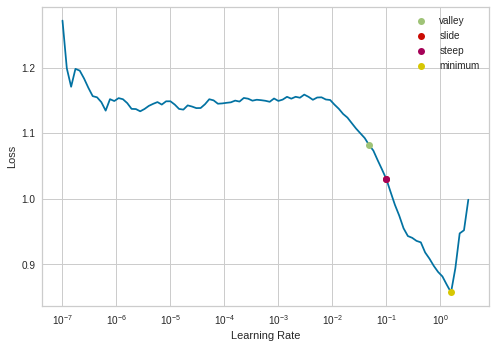

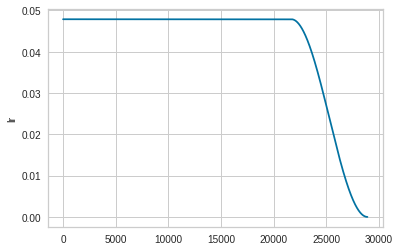

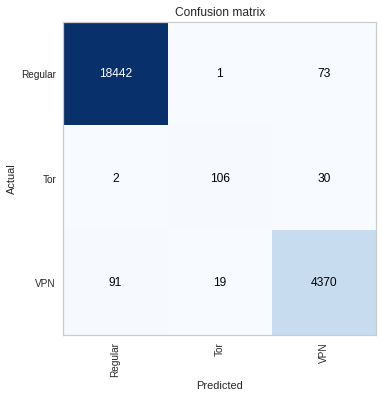

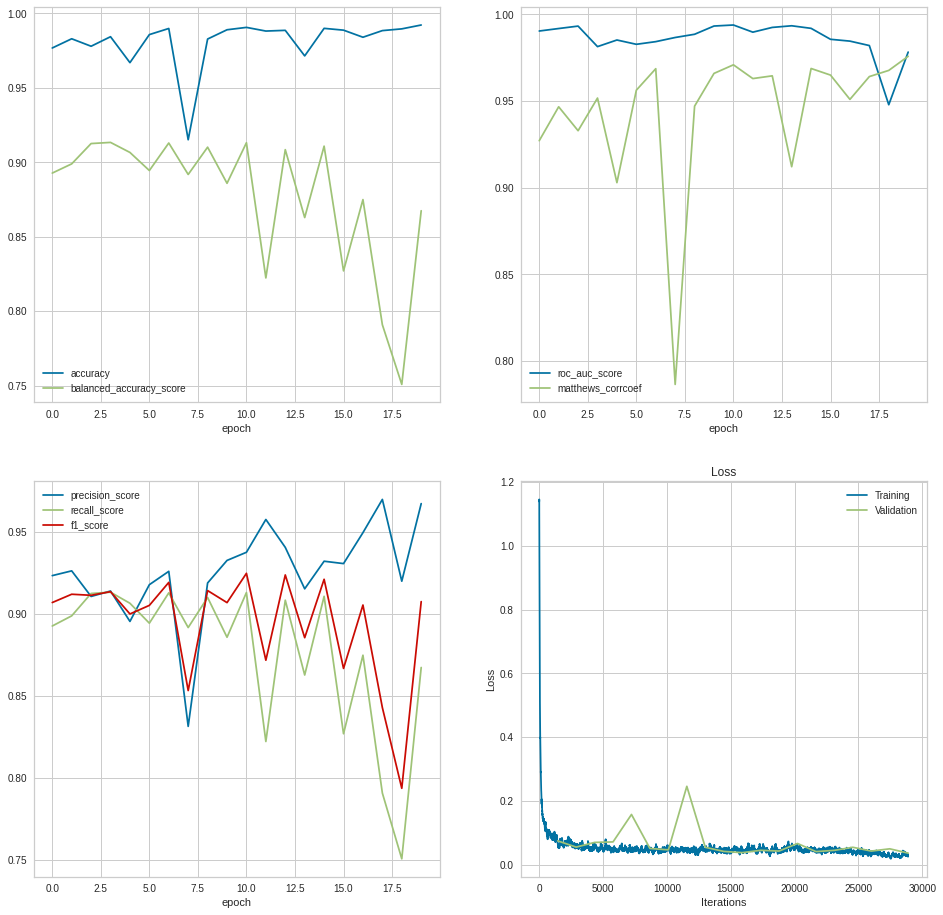

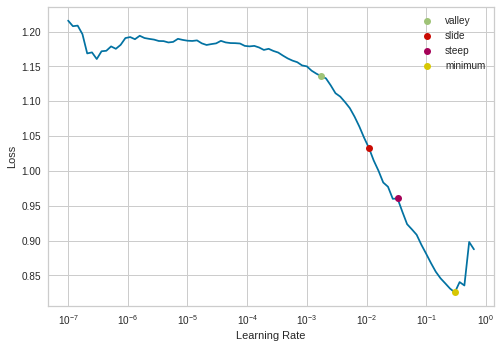

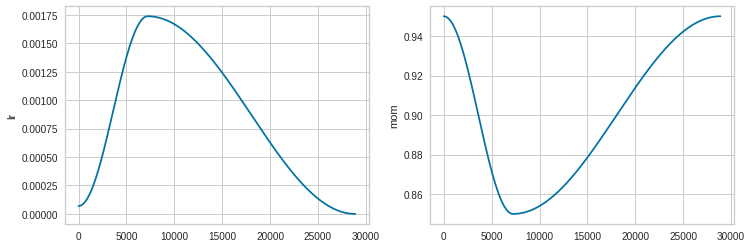

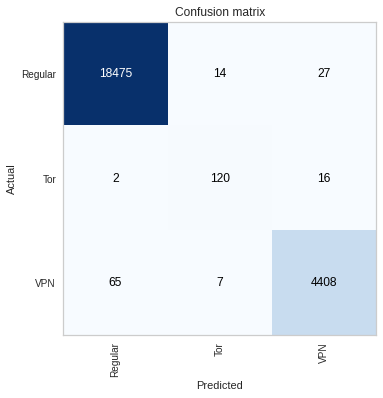

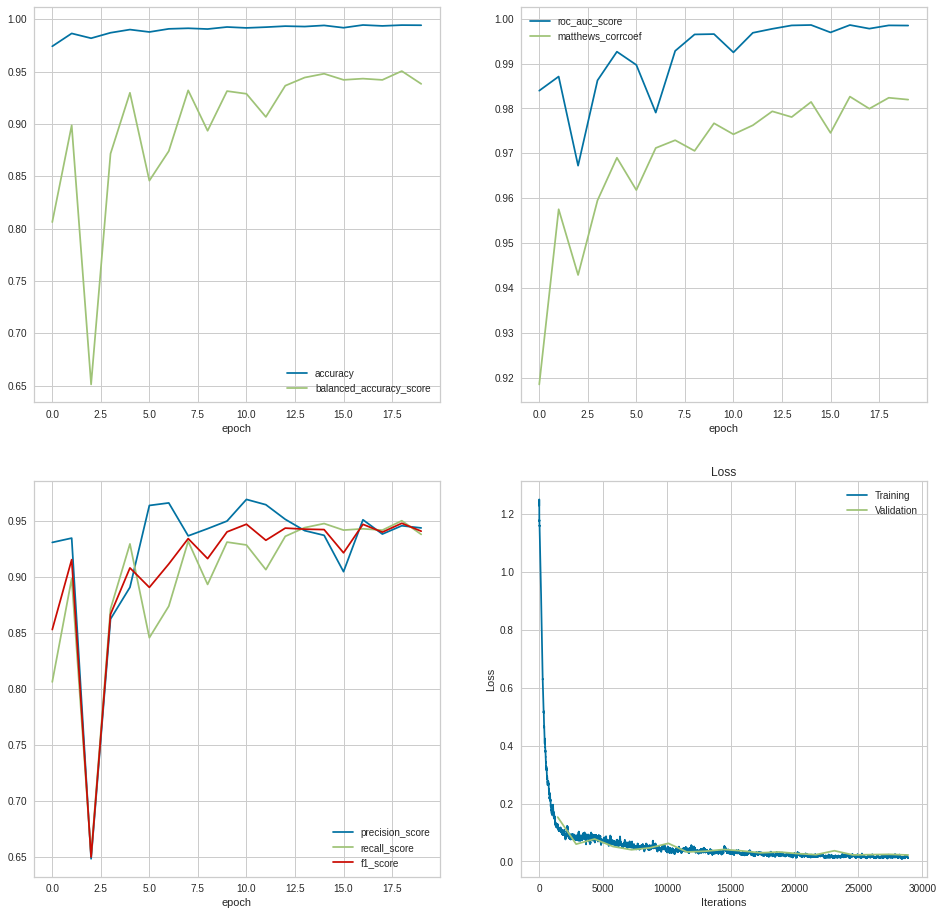

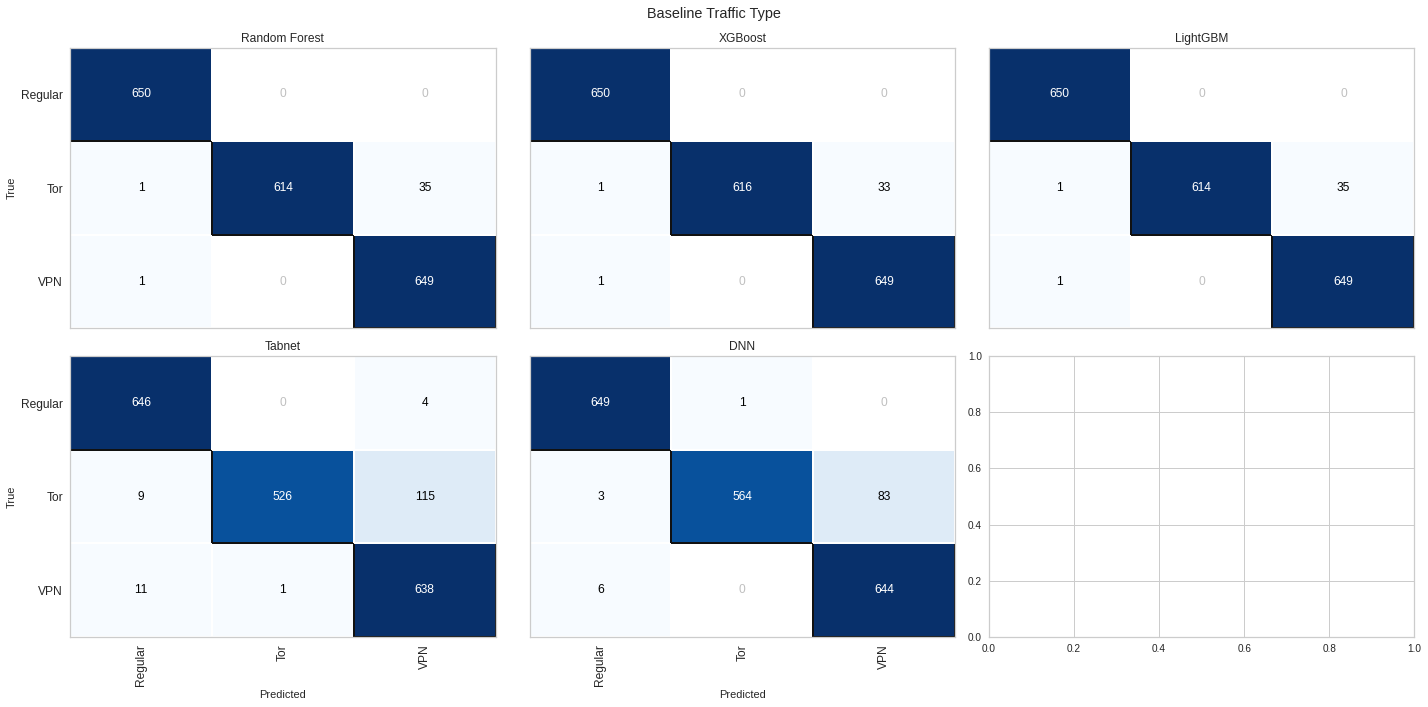

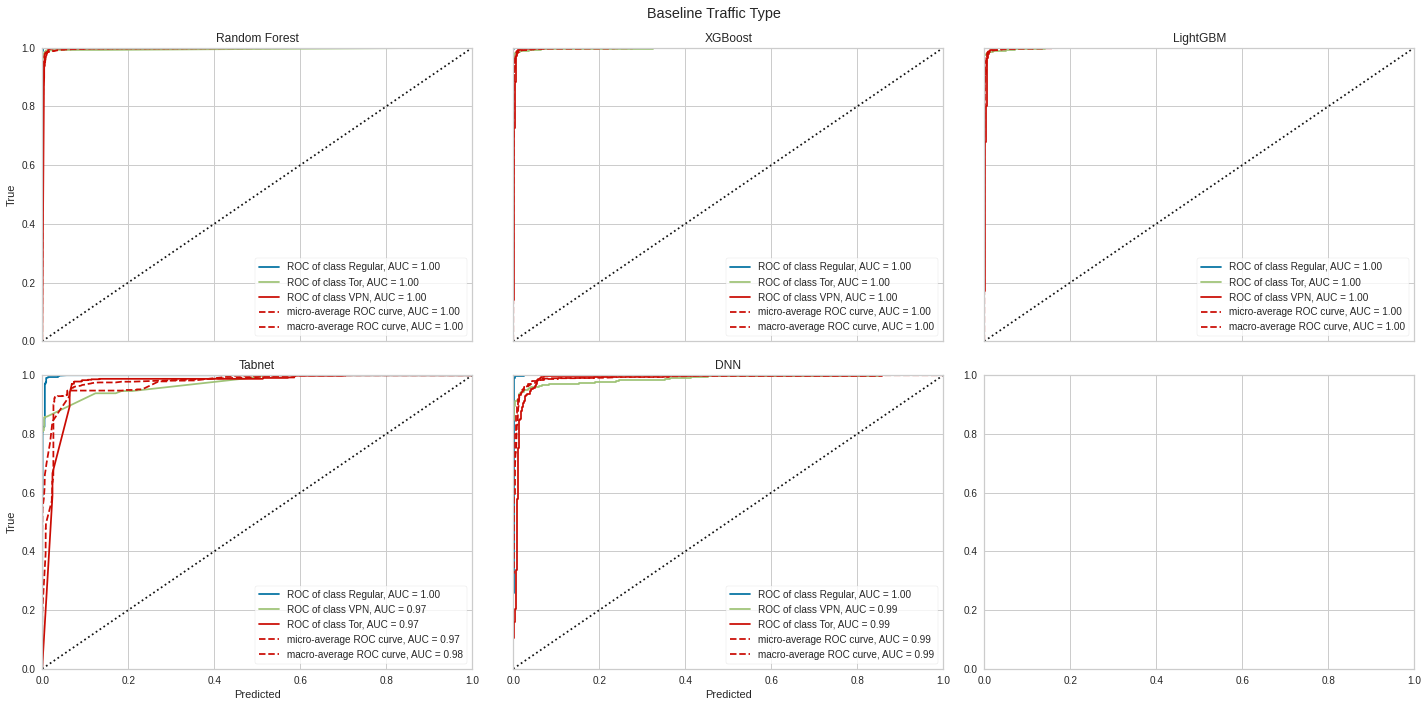

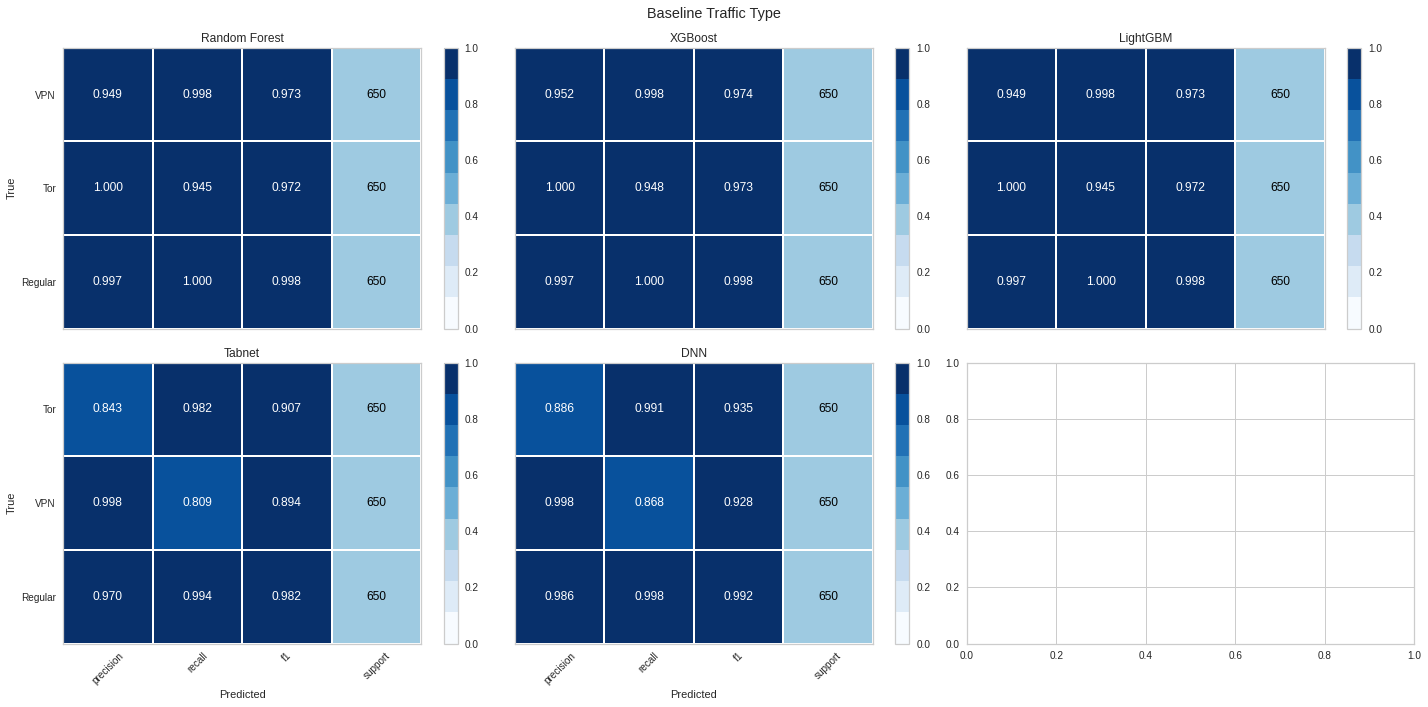

In [67]:
logger_1 = utils.DFLogger()
collector_1 = utils.ModelStatsCallback()
grapher_1 = utils.LazyGraphCallback()
model_saver_1 = utils.SaveModelCallback(monitor='f1_score')
callbacks_1 = [logger_1, grapher_1, model_saver_1, collector_1]

logger_2 = utils.DFLogger()
collector_2 = utils.ModelStatsCallback()
grapher_2 = utils.LazyGraphCallback()
model_saver_2 = utils.SaveModelCallback(monitor='f1_score')
callbacks_2 = [logger_2, grapher_2, model_saver_2, collector_2]

boost_param_grid = {
        "classifier__n_estimators": [100],
        'classifier__max_depth': [2,6,12],
        'classifier__min_child_weight': [4,10],
        "classifier__eval_metric": ["mlogloss"]
}
rf_param_grid = {
        'classifier__n_estimators': [100, 500],
        'classifier__max_features': ['auto', 'sqrt', 'log2'],
}


classifiers = [ utils.RandomForestClassifier(), utils.XGBClassifier(),  utils.LGBMClassifier(),
               "utils.run_tabnet_experiment(baseline_traffic_seed['Dataset'], 'Tabnet', 'Traffic Type', epochs=20, callbacks=callbacks_1, no_bar=True)",
                "utils.run_deep_nn_experiment(baseline_traffic_seed['Dataset'], 'Deep Neural Network', 'Traffic Type', list(125 for i in range(15)), epochs=20, callbacks=callbacks_2, no_bar=True)"
               ]


classifier_names = ["Random Forest", "XGBoost", "LightGBM",  "Tabnet", "DNN"]
shallow_classifiers = ["Random Forest", "XGBoost", "LightGBM"]
param_grids = [ rf_param_grid, boost_param_grid, boost_param_grid ]
baseline_traffic_results = train_and_evaluate_n_classifiers(baseline_traffic_seed['Dataset'], classifiers, "Traffic Type", classifier_names, shallow_classifiers,"Baseline Traffic Type", param_grids, baseline_traffic_test['Dataset'], [callbacks_1, callbacks_2])

# Application Type Classification

### Baseline

Results for Random Forest
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2803
           1       0.89      0.94      0.92      6482
           2       0.95      0.93      0.94       868
           3       0.80      0.66      0.72       122
           4       0.85      0.79      0.82      1742
           5       0.97      0.97      0.97      9625
           6       0.83      0.72      0.77       880
           7       0.98      0.94      0.96       202

    accuracy                           0.93     22724
   macro avg       0.91      0.86      0.88     22724
weighted avg       0.93      0.93      0.93     22724

	Accuracy: 0.9333303995775392

	F1: 0.9326923047797269

	AUC: 0.9890712108723458

	Mathew's Correlation: 0.906601919521012

[19:31:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective '

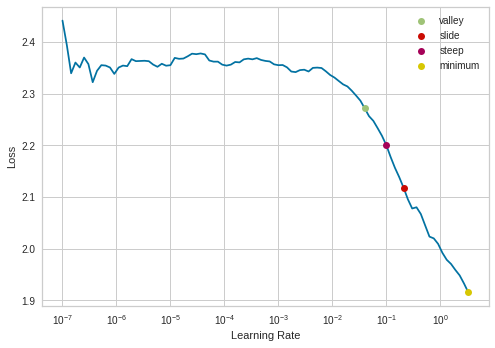

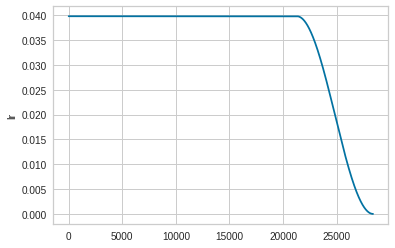

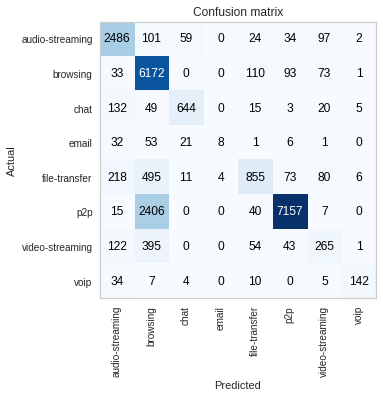

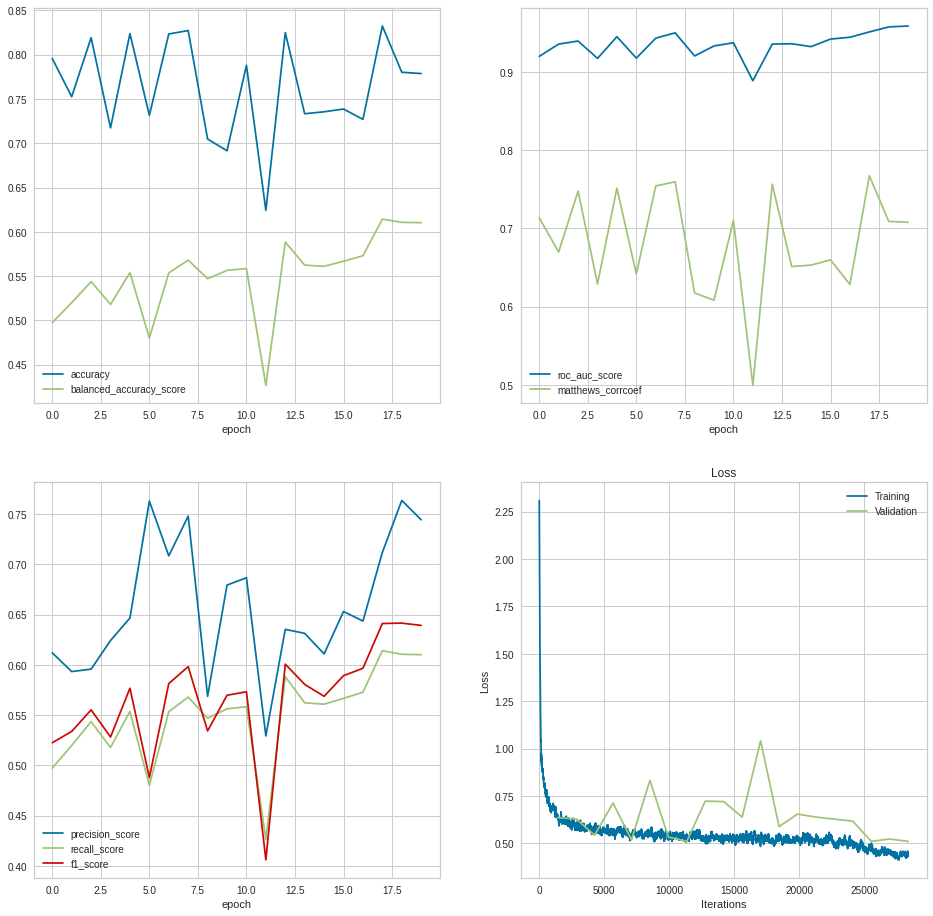

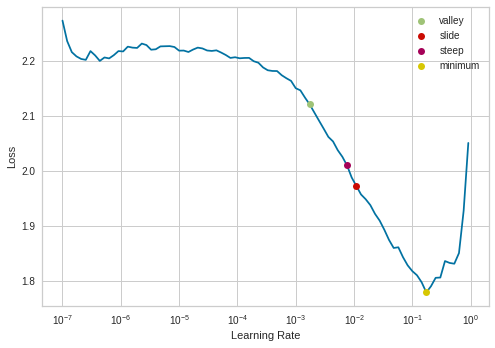

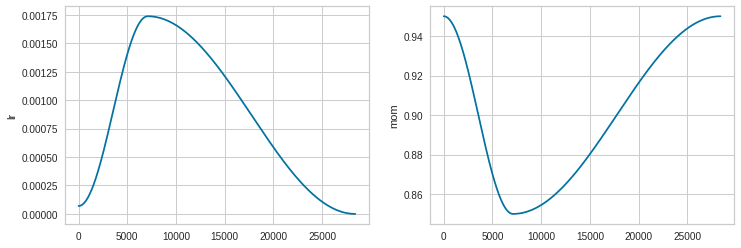

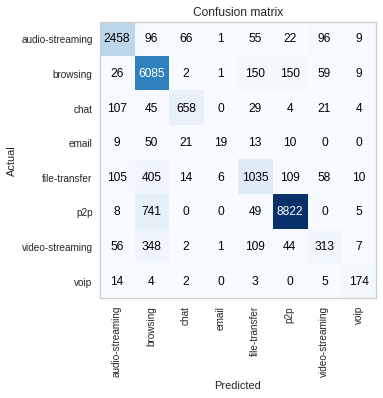

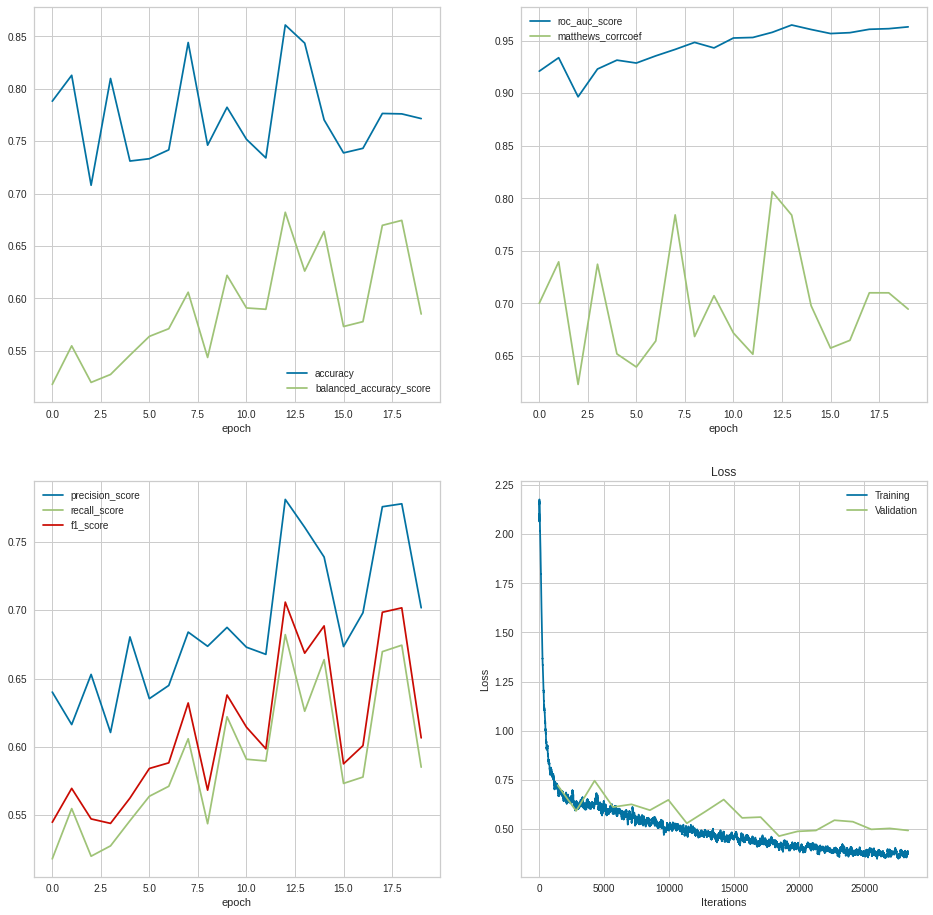

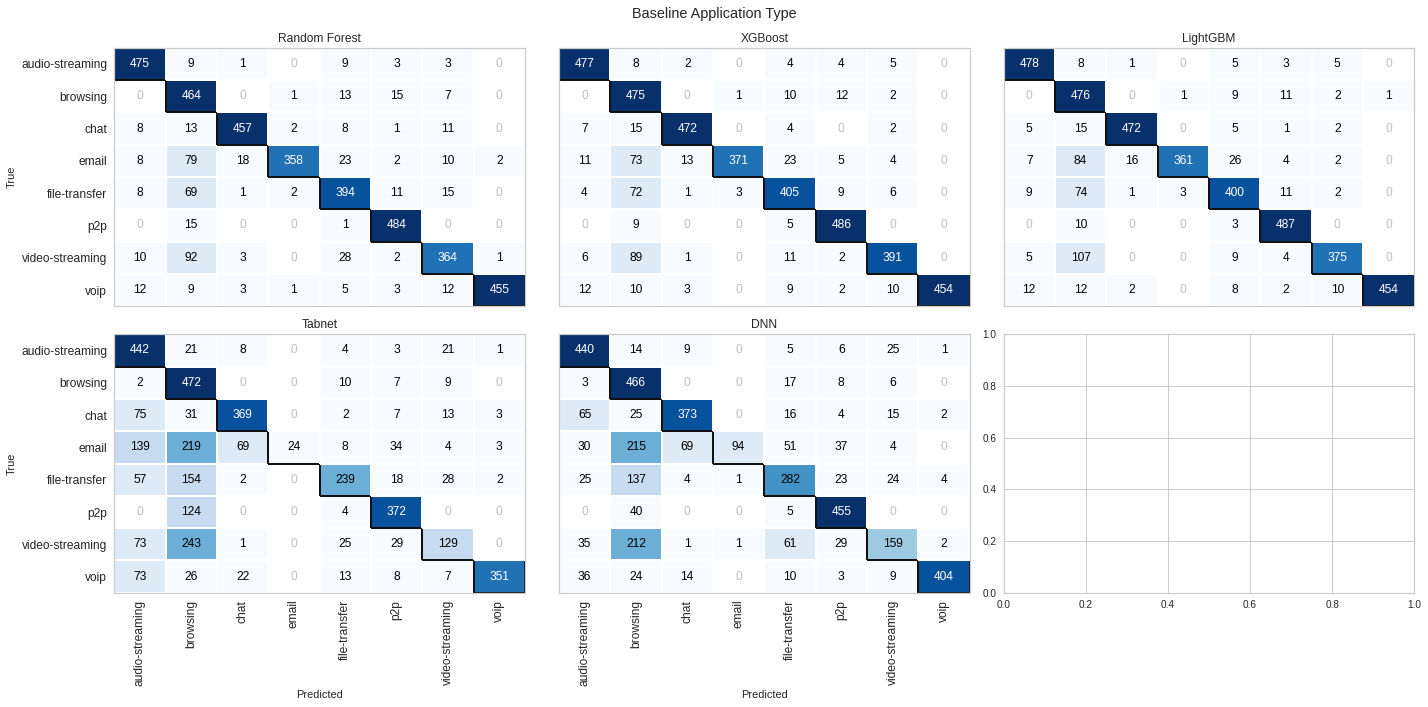

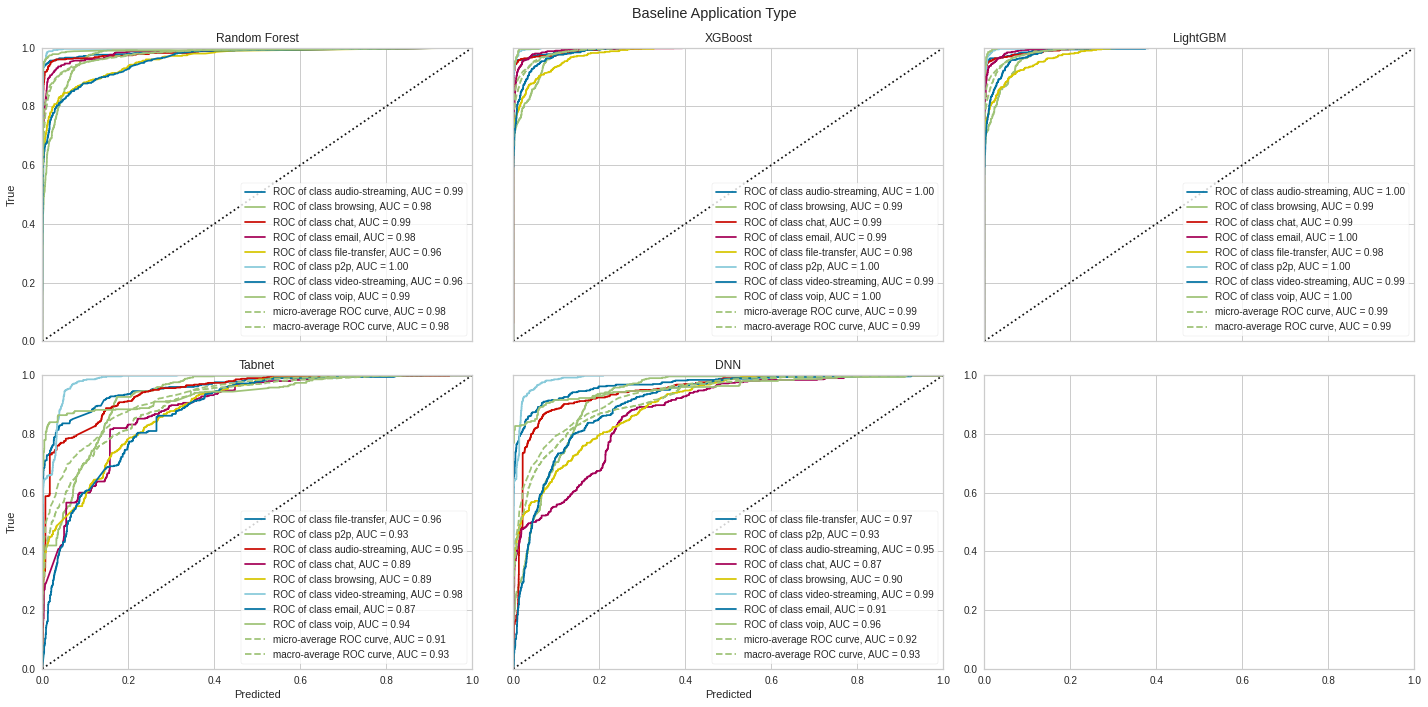

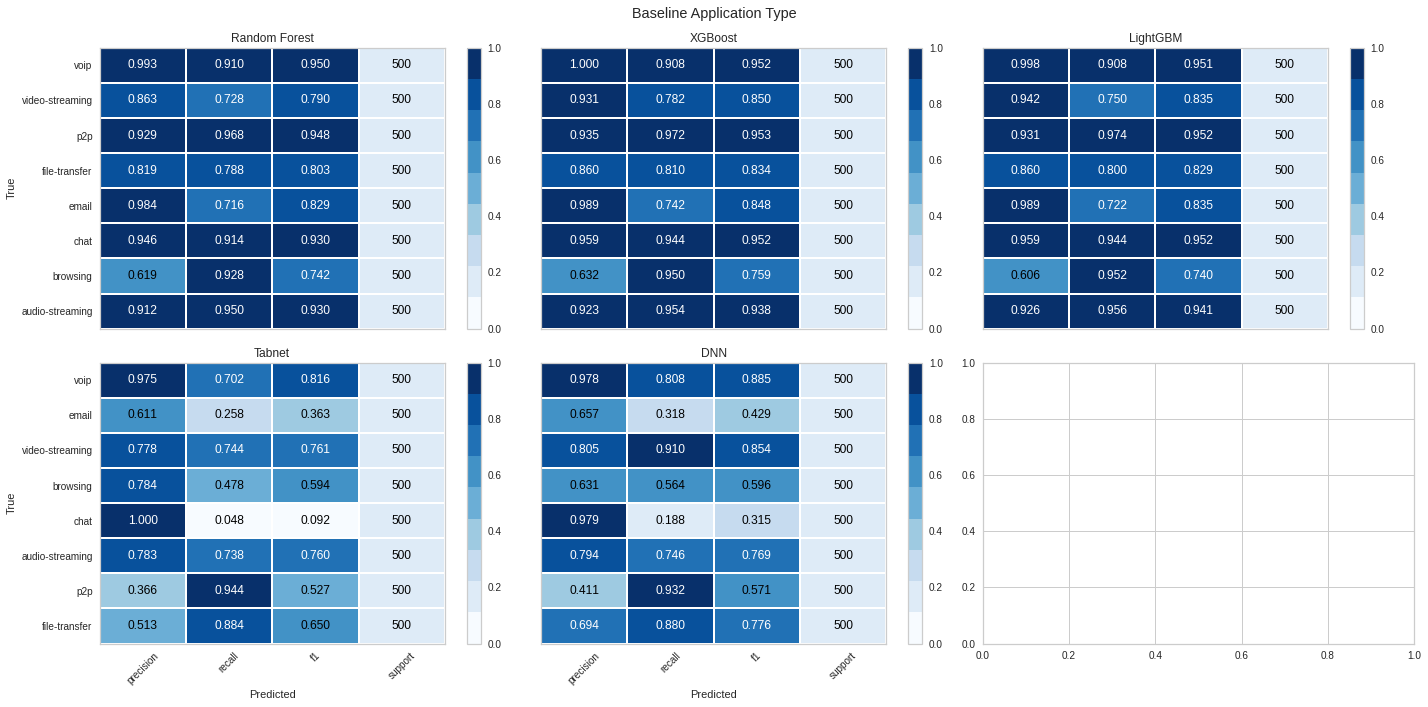

In [68]:
logger_1 = utils.DFLogger()
collector_1 = utils.ModelStatsCallback()
grapher_1 = utils.LazyGraphCallback()
model_saver_1 = utils.SaveModelCallback(monitor='f1_score')
callbacks_1 = [logger_1, grapher_1, model_saver_1, collector_1]

logger_2 = utils.DFLogger()
collector_2 = utils.ModelStatsCallback()
grapher_2 = utils.LazyGraphCallback()
model_saver_2 = utils.SaveModelCallback(monitor='f1_score')
callbacks_2 = [logger_2, grapher_2, model_saver_2, collector_2]

boost_param_grid = {
        "classifier__n_estimators": [100],
        'classifier__max_depth': [2,6,12],
        'classifier__min_child_weight': [4,10],
        "classifier__eval_metric": ["mlogloss"]
}
rf_param_grid = {
        'classifier__n_estimators': [100, 500],
        'classifier__max_features': ['auto', 'sqrt', 'log2'],
}


classifiers = [ utils.RandomForestClassifier(), utils.XGBClassifier(),  utils.LGBMClassifier(),
               "utils.run_tabnet_experiment(baseline_application_seed['Dataset'], 'Tabnet', 'Application Type', epochs=20, callbacks=callbacks_1, no_bar=True)",
                "utils.run_deep_nn_experiment(baseline_application_seed['Dataset'], 'Deep Neural Network', 'Application Type', list(125 for i in range(15)), epochs=20, callbacks=callbacks_2, no_bar=True)"
               ]

classifier_names = ["Random Forest", "XGBoost", "LightGBM",  "Tabnet", "DNN"]
shallow_classifiers = ["Random Forest", "XGBoost", "LightGBM"]
param_grids = [ rf_param_grid, boost_param_grid, boost_param_grid ]
baseline_application_results = train_and_evaluate_n_classifiers(baseline_application_seed['Dataset'], classifiers, "Application Type", classifier_names, shallow_classifiers,"Baseline Application Type", param_grids, baseline_application_test['Dataset'], [callbacks_1, callbacks_2])

In [11]:
print(f'Last Execution: {utils.datetime.datetime.now()}')
assert False, 'Nothing after this point is included in the study'

Last Execution: 2022-04-22 20:30:12.733536


AssertionError: Nothing after this point is included in the study